In [28]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
import csv 
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')  # Sử dụng kiểu phong cách hợp lệ
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import FuncFormatter
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [29]:
df = pd.read_excel("Data_DAP.xlsx")

print("Original Data:")
print(df.head())

Original Data:
                                              title         price  timeStamp  \
0  XM MINH HUY- Hỗ Trợ Trả Góp Xe Đã Qua Sử Dụng  68.686.868 đ        NaN   
1      XE MÁY TÚ TÀI- CHUYÊN CÁC DÒNG HONDA CAO CẤP  68.686.868 đ        NaN   
2             Sh CBS 150cc 2018 biển số TP.Nam Định  62.999.999 đ        NaN   
3                      Xe LEAD nguyên bản, như hình   6.800.000 đ        NaN   
4       Honda Air Blade 125. Bản Sporrt. Chính chủ.  15.600.000 đ        NaN   

    hang       dong  namdangki   soKM   tinhTrang  loaiXe      dungTich  \
0  Honda         SH       2022   8000  Đã sử dụng  Tay ga           NaN   
1  Honda         SH       2022   1000  Đã sử dụng  Tay ga  100 - 175 cc   
2  Honda         SH       2018   8900  Đã sử dụng  Tay ga  100 - 175 cc   
3  Honda       Lead       2012  16800  Đã sử dụng  Tay ga  100 - 175 cc   
4  Honda  Air Blade       2016  18600  Đã sử dụng  Tay ga  100 - 175 cc   

   xuatXu    chinhSachBH TrongLuong  
0     NaN  Bảo 

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        3355 non-null   object 
 1   price        3355 non-null   object 
 2   timeStamp    0 non-null      float64
 3   hang         3355 non-null   object 
 4   dong         3355 non-null   object 
 5   namdangki    3355 non-null   int64  
 6   soKM         3355 non-null   int64  
 7   tinhTrang    3355 non-null   object 
 8   loaiXe       3355 non-null   object 
 9   dungTich     2941 non-null   object 
 10  xuatXu       0 non-null      float64
 11  chinhSachBH  3355 non-null   object 
 12  TrongLuong   3355 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 340.9+ KB


In [31]:
print('Rows     :',df.shape[0])
print('Columns  :',df.shape[1])
print('\nFeatures :\n     :',df.columns.tolist())
print('\nMissing values    :',df.isnull().values.sum())
print('\nUnique values :  \n',df.nunique())

Rows     : 3355
Columns  : 13

Features :
     : ['title', 'price', 'timeStamp', 'hang', 'dong', 'namdangki', 'soKM', 'tinhTrang', 'loaiXe', 'dungTich', 'xuatXu', 'chinhSachBH', 'TrongLuong']

Missing values    : 7124

Unique values :  
 title          2935
price           448
timeStamp         0
hang             25
dong            125
namdangki        38
soKM            432
tinhTrang         1
loaiXe            3
dungTich          5
xuatXu            0
chinhSachBH       1
TrongLuong        1
dtype: int64


1. Data Processing

In [32]:
df['price'] = df['price'].str.replace('.', '').str.replace('đ', '')
df.drop(columns=['timeStamp'], inplace=True)
df.drop(columns=['xuatXu'], inplace=True)
df.drop(columns=['title'], inplace=True)
df.drop(columns=['TrongLuong'], inplace=True)

2. Mising Values

In [33]:
total = df.isnull().sum().sort_values(ascending=False)
percent = ((df.isnull().sum())*100)/df.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], 
                         sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
dungTich,414,12.339791
price,0,0.000000
hang,0,0.000000
dong,0,0.000000
namdangki,0,0.000000
soKM,0,0.000000
tinhTrang,0,0.000000
loaiXe,0,0.000000
chinhSachBH,0,0.000000


In [34]:
df['dungTich'].fillna('?', inplace=True)


filtered_data = df[df['dungTich'].str.count('\?') > 0]['dong']

# In ra các dòng duy nhất trong cột 'dong'
unique_dongs_with_question_mark = filtered_data.unique()

# In ra tên các dòng unique trong cột 'dong' có kí tự '?' ở cột 'dungTich' tương ứng
for dong in unique_dongs_with_question_mark:
    print("Row:", dong, "- have missing value:", 
          filtered_data[filtered_data == dong].count())

Row: SH - have missing value: 10
Row: Vision - have missing value: 46
Row: Exciter - have missing value: 68
Row: Winner X - have missing value: 33
Row: Wave - have missing value: 58
Row: Winner - have missing value: 19
Row: Lead - have missing value: 15
Row: Liberty - have missing value: 14
Row: Air Blade - have missing value: 49
Row: Nouvo - have missing value: 11
Row: Vespa - have missing value: 54
Row: Dream - have missing value: 15
Row: R - have missing value: 12
Row: Dòng khác - have missing value: 9
Row: Blade - have missing value: 1


2.1. Handeling Missing Value

In [35]:
dong_list = ['SH', 'Vision', 'Exciter', 'Winner X', 'Wave', 'Winner', 'Lead', 'Liberty', 
             'Air Blade', 'Nouvo', 'Vespa', 'Dream', 'R', 'Dòng khác', 'Blade']

# Lặp qua từng dòng và in ra các giá trị tần suất của cột 'dungTich'
for dong in dong_list:
    # Lọc dữ liệu cho dòng hiện tại
    a = df[df['dong'] == dong]
    
    # In ra thông tin số lượng giá trị trong cột 'dungTich'
    print("Row:", dong, "- have missing value:", 
          filtered_data[filtered_data == dong].count())
    print(a['dungTich'].value_counts())
    print()

Row: SH - have missing value: 10
dungTich
100 - 175 cc    258
?                10
Trên 175 cc       3
50 - 100 cc       2
Name: count, dtype: int64

Row: Vision - have missing value: 46
dungTich
100 - 175 cc    196
?                46
50 - 100 cc       3
Trên 175 cc       1
Name: count, dtype: int64

Row: Exciter - have missing value: 68
dungTich
100 - 175 cc    157
?                68
Name: count, dtype: int64

Row: Winner X - have missing value: 33
dungTich
100 - 175 cc    47
?               33
50 - 100 cc      1
Trên 175 cc      1
Name: count, dtype: int64

Row: Wave - have missing value: 58
dungTich
100 - 175 cc     265
?                 58
50 - 100 cc       27
Dưới 50 cc         2
Không biết rõ      1
Name: count, dtype: int64

Row: Winner - have missing value: 19
dungTich
100 - 175 cc    35
?               19
Trên 175 cc      1
Name: count, dtype: int64

Row: Lead - have missing value: 15
dungTich
100 - 175 cc    151
?                15
50 - 100 cc       1
Name: count, dtype: int

In [36]:
df['price'] = df['price'].astype(float)
df['price'] = df['price'].astype(int)
df = df[(df['dungTich'] != 'Không biết rõ') & (df['dong'] != 'Dòng khác')]

In [37]:
for dong in dong_list:
    # Lọc dữ liệu cho dòng hiện tại
    a = df[df['dong'] == dong]
    
    # Tìm giá trị cao nhất trong cột 'dungTich'
    max_value = df['dungTich'].mode().values[0]
    
    # Thay thế giá trị '?' trong cột 'dungTich' bằng giá trị cao nhất
    df.loc[(df['dong'] == dong) & (df['dungTich'] == '?'), 'dungTich'] = max_value
print(df.head(5
))

      price   hang       dong  namdangki   soKM   tinhTrang  loaiXe  \
0  68686868  Honda         SH       2022   8000  Đã sử dụng  Tay ga   
1  68686868  Honda         SH       2022   1000  Đã sử dụng  Tay ga   
2  62999999  Honda         SH       2018   8900  Đã sử dụng  Tay ga   
3   6800000  Honda       Lead       2012  16800  Đã sử dụng  Tay ga   
4  15600000  Honda  Air Blade       2016  18600  Đã sử dụng  Tay ga   

       dungTich    chinhSachBH  
0  100 - 175 cc  Bảo hành hãng  
1  100 - 175 cc  Bảo hành hãng  
2  100 - 175 cc  Bảo hành hãng  
3  100 - 175 cc  Bảo hành hãng  
4  100 - 175 cc  Bảo hành hãng  


3. Visualize Data

In [38]:
print('Rows     :',df.shape[0])
print('Columns  :',df.shape[1])
print('\nFeatures :\n     :',df.columns.tolist())
print('\nMissing values    :',df.isnull().values.sum())
print('\nUnique values :  \n',df.nunique())

Rows     : 3269
Columns  : 9

Features :
     : ['price', 'hang', 'dong', 'namdangki', 'soKM', 'tinhTrang', 'loaiXe', 'dungTich', 'chinhSachBH']

Missing values    : 0

Unique values :  
 price          439
hang            23
dong           124
namdangki       38
soKM           422
tinhTrang        1
loaiXe           3
dungTich         4
chinhSachBH      1
dtype: int64


In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,3269.0,2.417366e+07,3.061297e+07,11511.0,9000000.0,16500000.0,26800000.0,455000000.0
namdangki,3269.0,2.017337e+03,5.180361e+00,1981.0,2015.0,2018.0,2021.0,2024.0
soKM,3269.0,1.604268e+04,5.650262e+04,1.0,2000.0,5999.0,12000.0,986422.0


Some important observations from the dataset:

Lowest namdangki is 1981, highest is 2024

Highest soKM is 986,422

Price is 23,919,510 vnd

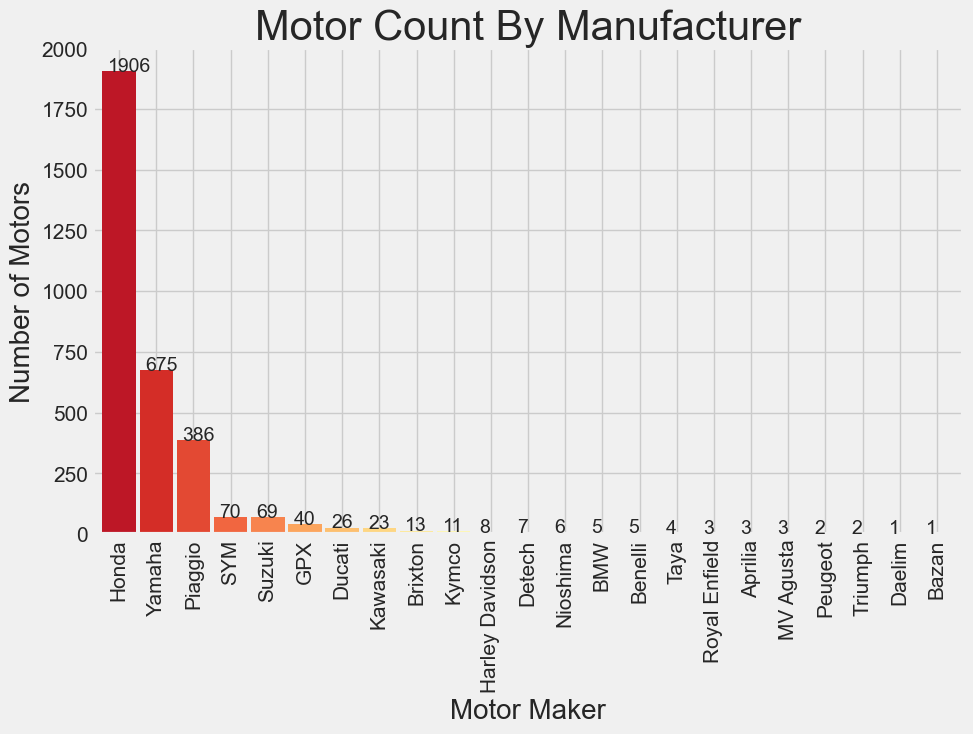

In [40]:
plt.subplots(figsize=(10,6))
ax=df['hang'].value_counts().plot.bar(width=0.9,color=sns.color_palette('RdYlGn',20))
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.xticks(rotation='vertical')
plt.xlabel('Motor Maker',fontsize=20)
plt.ylabel('Number of Motors',fontsize=20)
plt.title('Motor Count By Manufacturer',fontsize=30)
ax.tick_params(labelsize=15)
#plt.yticks(rotation='vertical')
plt.show()
plt.show()

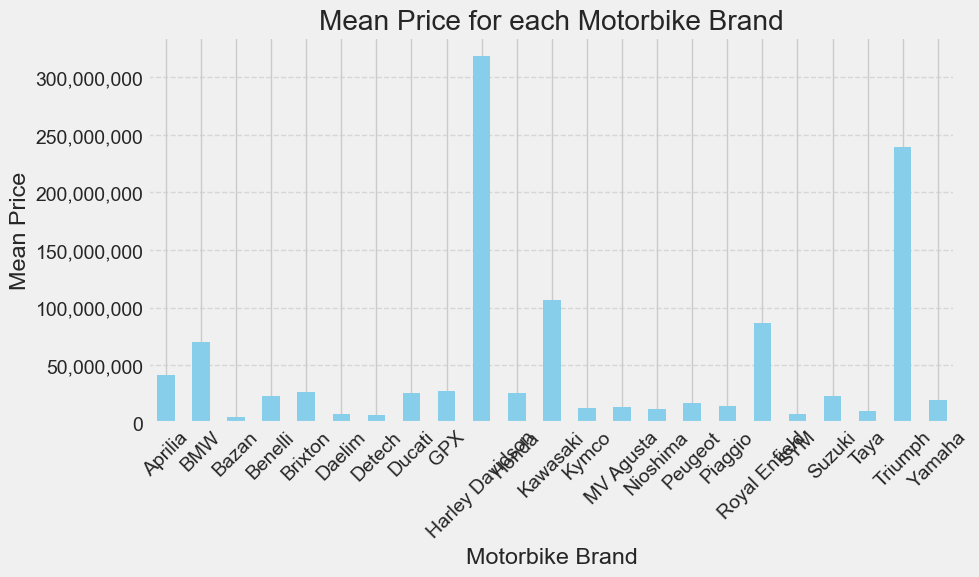

In [41]:
# Tính giá trung bình theo hãng
average_prices = df.groupby('hang')['price'].mean()

# Định dạng giá trị trục y
def y_format(x, pos):
    return '{:,.0f}'.format(x)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
average_prices.plot(kind='bar', color='skyblue')
plt.title('Mean Price for each Motorbike Brand')
plt.xlabel('Motorbike Brand')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Sử dụng formatter cho trục y
formatter = FuncFormatter(y_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

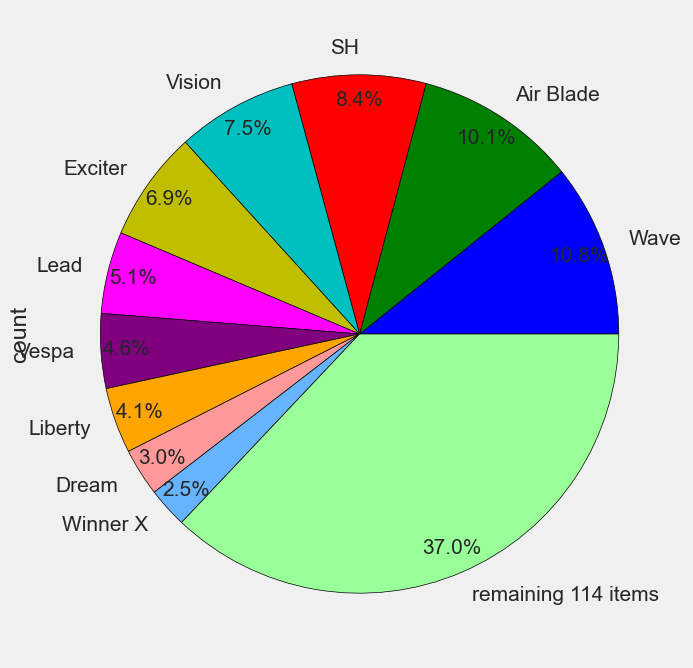

In [42]:
colors = ['b','g','r','c','y','magenta','purple','orange','#ff9999','#66b3ff','#99ff99']
temp = df['dong'].value_counts()
temp2 = temp.head(10)
if len(temp) > 10:
   temp2['remaining {0} items'.format(len(temp)-10)] = sum(temp[10:])
temp2.plot(kind='pie',autopct="%1.1f%%",shadow=False,fontsize=15,pctdistance=0.9,
           colors=colors,wedgeprops={"edgecolor":"0","linewidth":0.5,"linestyle":"solid","antialiased":True},
           figsize=(10,8)) 

pass

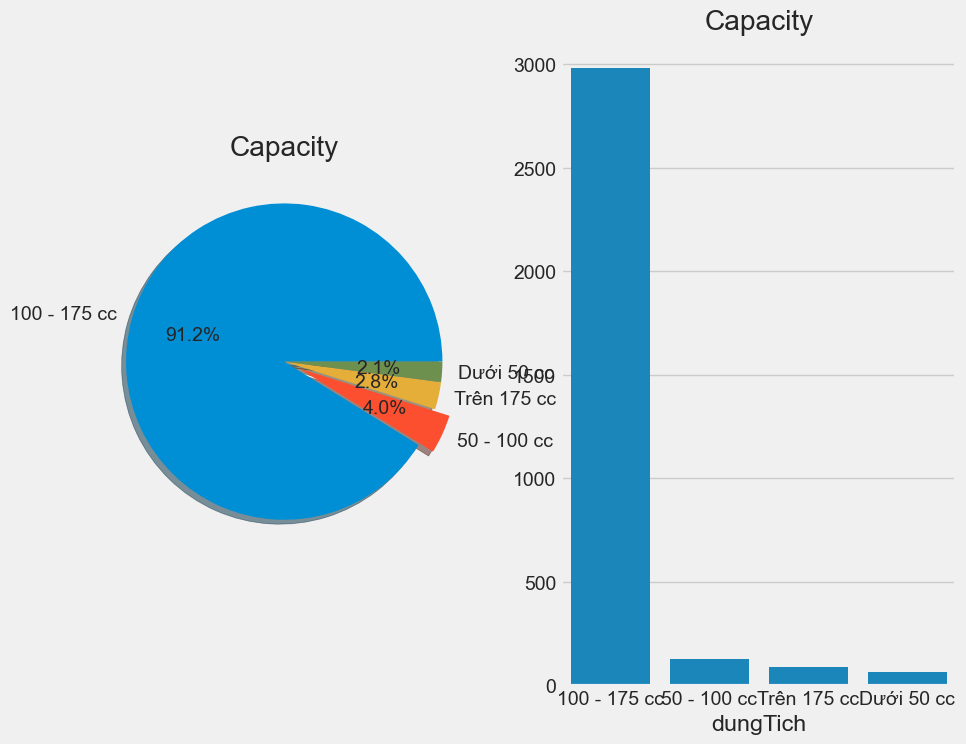

In [43]:
cross_tab = pd.crosstab(df['dong'], df['dungTich'], margins=True)

# Apply background gradient to the transposed crosstab
styled_cross_tab = cross_tab.T.style.background_gradient(cmap='summer_r')

# Plot pie chart and countplot for 'dungTich' column
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

# Plot pie chart
dungTich_counts = df['dungTich'].value_counts()
explode = [0] * len(dungTich_counts)  # Create an explode list of zeros
explode[1] = 0.1  # Set explode for the second wedge to 0.1
dungTich_counts.plot.pie(explode=explode, autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Capacity')
ax[0].set_ylabel('')

# Plot countplot
sns.countplot(x='dungTich', data=df, ax=ax[1], order=dungTich_counts.index)
ax[1].set_title('Capacity')
ax[1].set_ylabel('')
plt.show()

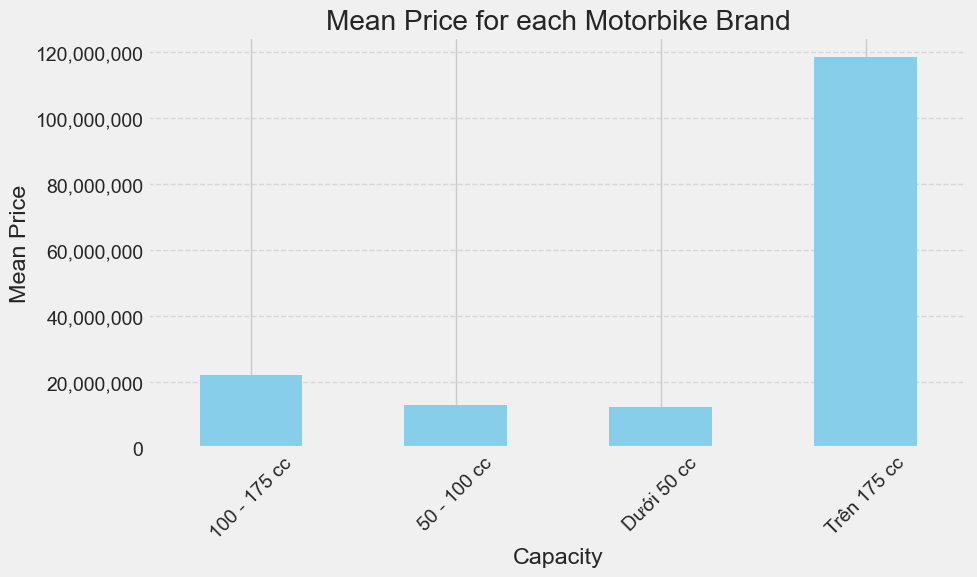

In [44]:
# Tính giá trung bình theo hãng
average_capacity = df.groupby('dungTich')['price'].mean()

# Định dạng giá trị trục y
def y_format(x, pos):
    return '{:,.0f}'.format(x)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
average_capacity.plot(kind='bar', color='skyblue')
plt.title('Mean Price for each Motorbike Brand')
plt.xlabel('Capacity')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Sử dụng formatter cho trục y
# formatter = FuncFormatter(y_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

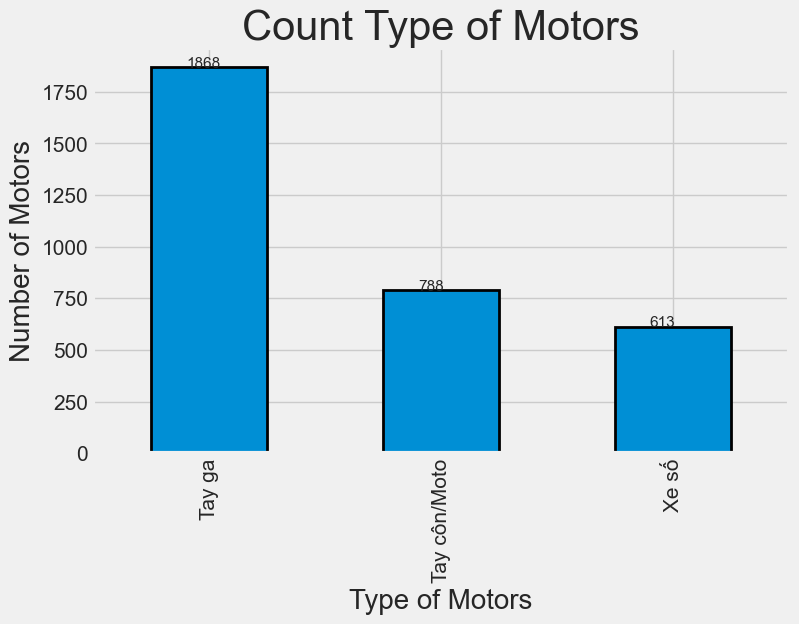

In [45]:
fig = plt.figure(figsize=(8, 5))
cars_type=df.groupby(['loaiXe']).count()['tinhTrang']
ax=cars_type.sort_values(ascending=False).plot.bar(edgecolor='k',linewidth=2)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.15, p.get_height()+1),fontsize=11)
plt.xticks(rotation='vertical')
plt.xlabel('Type of Motors',fontsize=20)
plt.ylabel('Number of Motors',fontsize=20)
plt.title('Count Type of Motors',fontsize=30)
ax.tick_params(labelsize=15)
#plt.yticks(rotation='vertical')
plt.show()

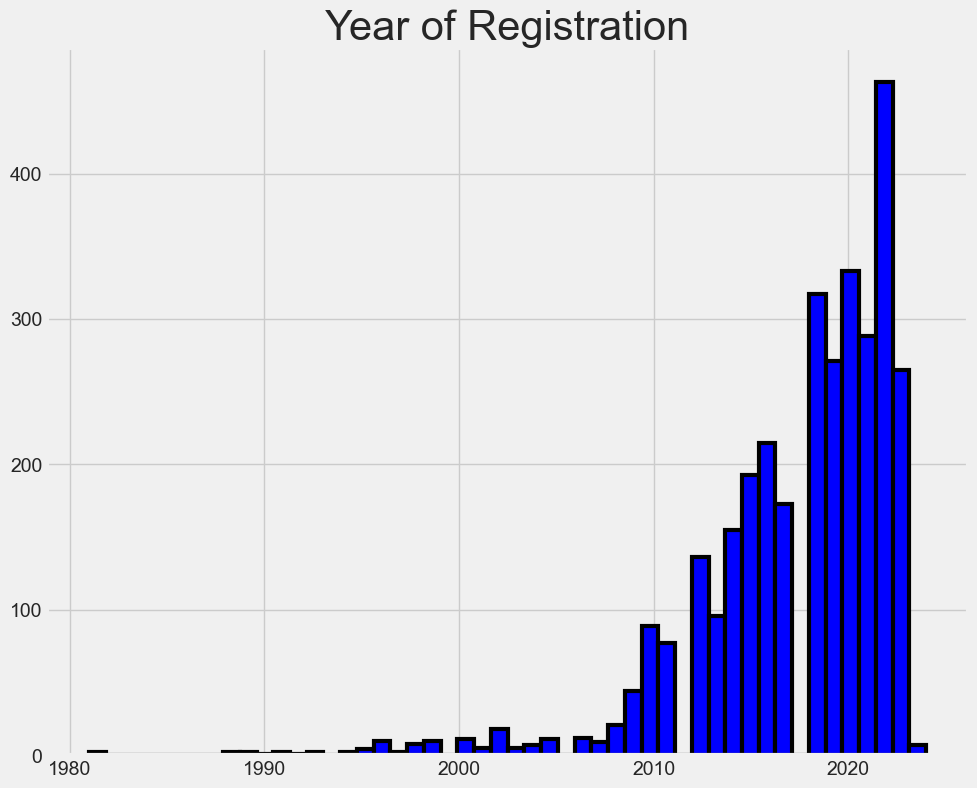

In [46]:
df[['namdangki']].hist(figsize=(10, 8), bins=50, color='b', linewidth=3, edgecolor='k')
plt.tight_layout()
plt.title('Year of Registration',fontsize=30)
plt.show()

In [48]:
data = df.copy(deep=False)

4. Building Machine Learning Model

In [49]:
from sklearn.model_selection import train_test_split

# split the dataset into training and test set
train, test = train_test_split(data, test_size=0.2, random_state=122)

# check the dimension of the training and test dataset
print('Training dataset: ', train.shape)
print('Test dataset: ', test.shape)

Training dataset:  (2615, 9)
Test dataset:  (654, 9)


In [50]:
train_check = train.copy(deep=True)

test_check = test.copy(deep=True)

In [51]:
# segregate the feature matrix and target vector
Xtrain = train.drop(columns=['price'], axis=1)
ytrain = train['price']

Xtest = test.drop(columns=['price'], axis=1)
ytest = test['price']

In [52]:
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# categorical columns
categorical_features = ['hang', 'dong', 'tinhTrang', 'loaiXe', 'dungTich', 'chinhSachBH']

# numeric columns
numeric_features = ['namdangki', 'soKM']

# create transformers
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unknown categories
])


# create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ])

# create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', MaxAbsScaler())])


In [53]:
# perform feature transformation to train and test dataset
Xtrain_processed = pipeline.fit_transform(Xtrain)
Xtest_processed = pipeline.transform(Xtest)


In [54]:
# transform the 'Price' value into log scale
ytrain_log = np.log(ytrain)
ytest_log = np.log(ytest)

In [55]:
from sklearn.impute import SimpleImputer

# Convert ytrain_log to 2D array
ytrain_log_2d = np.array(ytrain_log).reshape(-1, 1)

imputer = SimpleImputer(strategy='mean')

Xtrain_processed_imputed = imputer.fit_transform(Xtrain_processed)
ytrain_log_imputed = imputer.fit_transform(ytrain_log_2d)

Model 1: Decision Tree

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# create a Decision Tree Regressor
tree = DecisionTreeRegressor()

# define the hyperparameter grid to search
# param_grid = {
#     'max_depth': [10, 20, 30],              # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4]           # Minimum number of samples required to be at a leaf node
# }

param_grid = {
    'max_depth': [30],              # Maximum depth of the tree
    'min_samples_split': [10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2]           # Minimum number of samples required to be at a leaf node
}
# create the GridSearchCV object
grid_search_tree = GridSearchCV(estimator=tree, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# fit the model to the training data
grid_search_tree.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters
best_params = grid_search_tree.best_params_
print("Best Hyperparameters:", best_params)

# get the best model
best_tree = grid_search_tree.best_estimator_

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10}


Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [57]:
## Lưu mô hình Random Forest 
from joblib import dump
# Lưu mô hình
dump(best_tree, 'best_tree_model.joblib')

['best_tree_model.joblib']

Model 2: Random Forest

In [58]:
from sklearn.ensemble import RandomForestRegressor

# create a Random Forest Regressor
forest = RandomForestRegressor()

# define the hyperparameter grid to search
# param_grid = {
#     'n_estimators': [100, 200, 300],        # Number of trees in the forest
#     'max_depth': [10, 20, 30],              # Maximum depth of the trees
#     'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4]           # Minimum number of samples required to be at a leaf node
# }

param_grid = {
    'n_estimators': [300],        # Number of trees in the forest
    'max_depth': [30],              # Maximum depth of the trees
    'min_samples_split': [2],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1]           # Minimum number of samples required to be at a leaf node
}
# create the GridSearchCV object
grid_search_forest = GridSearchCV(estimator=forest, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# fit the model to the training data
grid_search_forest.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters
best_params = grid_search_forest.best_params_
print("Best Hyperparameters:", best_params)

# get the best model
best_forest = grid_search_forest.best_estimator_

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

In [59]:
## Lưu mô hình Random Forest 
from joblib import dump
# Lưu mô hình
dump(best_forest, 'best_random_forest_model.joblib')

['best_random_forest_model.joblib']

Model 3: KNN Regressor

In [60]:
from sklearn.neighbors import KNeighborsRegressor

# create a KNN Regressor
knn = KNeighborsRegressor(n_neighbors=2)

# define the hyperparameter grid to search
# param_grid = {
#     'n_neighbors': [2,4,6,8,10]
# }

param_grid = {
    'n_neighbors': [10]
}
# create the GridSearchCV object
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, 
                               scoring='neg_mean_squared_error', cv=5)
#neg_mean_squared_error để đánh giá bằng phương pháp sai số bình phương trung bình âm
# fit the model to the training data
grid_search_knn.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters
best_params = grid_search_knn.best_params_
print("Best Hyperparameters:", best_params)

# get the best model
best_knn = grid_search_knn.best_estimator_

Best Hyperparameters: {'n_neighbors': 10}


Best Hyperparameters: {'n_neighbors': 10}

In [61]:
## Lưu mô hình Random Forest 
from joblib import dump
# Lưu mô hình
dump(best_knn , 'best_knn_model.joblib')

['best_knn_model.joblib']

Model 4: Redge Regression

In [62]:
from sklearn.linear_model import Ridge

# create Ridge Regression model
ridge = Ridge()

# define the hyperparameter grid for Ridge Regression
# ridge_param_grid = {
#     'alpha': [0.1, 1, 10, 100]  # Regularization strength
# }

ridge_param_grid = {
    'alpha': [1]  # Regularization strength
}

# create the GridSearchCV object for Ridge Regression
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, scoring='neg_mean_squared_error', cv=5)

# fit the Ridge model to the training data
ridge_grid_search.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters for Ridge Regression
best_ridge_params = ridge_grid_search.best_params_
print("Best Ridge Hyperparameters:", best_ridge_params)

# get the best Ridge model
best_ridge = ridge_grid_search.best_estimator_

Best Ridge Hyperparameters: {'alpha': 1}


Best Ridge Hyperparameters: {'alpha': 1}

In [63]:
## Lưu mô hình Random Forest 
from joblib import dump
# Lưu mô hình
dump(best_ridge, 'best_ridge_model.joblib')

['best_ridge_model.joblib']

Model 5: Support Vector Regression 

In [65]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# create SVR model
svr = SVR()

# define the hyperparameter grid for SVR
# svr_param_grid = {
#     'C': [0.1, 1, 10, 100],  # Regularization strength
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
#     'gamma': ['scale', 'auto']  # Kernel coefficient
# }
svr_param_grid = {
    'C': [10],  # Regularization strength
    'kernel': ['poly'],  # Kernel type
    'gamma': ['scale']  # Kernel coefficient
}
# create the GridSearchCV object for SVR
svr_grid_search = GridSearchCV(estimator=svr, param_grid=svr_param_grid, scoring='neg_mean_squared_error', cv=5)

# fit the SVR model to the training data
svr_grid_search.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters for SVR
best_svr_params = svr_grid_search.best_params_
print("Best SVR Hyperparameters:", best_svr_params)

# get the best SVR model
best_svr = svr_grid_search.best_estimator_


Best SVR Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}


Best SVR Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}

In [66]:
## Lưu mô hình Random Forest 
from joblib import dump
# Lưu mô hình
dump(best_svr, 'best_svr_model.joblib')

['best_svr_model.joblib']

5. Model Evaluation

In [67]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def model_eval(X,y,clf,tag):
    ypred = clf.predict(X)
    
    r2 = r2_score(y, ypred)
    mse = mean_squared_error(y, ypred)
    rmse = mean_squared_error(y, ypred, squared=False)
    mae = mean_absolute_error(y, ypred)
    
    metrics = [r2, mse, rmse, mae]
    metricsName = ['R-Square', 'MSE', 'RMSE', 'MAE']
    
    res = pd.DataFrame(metrics, columns=[tag], index=metricsName)
    
    return res

In [68]:
from joblib import dump
import joblib
best_tree = joblib.load('best_tree_model.joblib')
best_forest = joblib.load('best_random_forest_model.joblib')
best_knn = joblib.load('best_knn_model.joblib')
best_ridge = joblib.load('best_ridge_model.joblib')
best_svr = joblib.load('best_svr_model.joblib')
tree_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_tree, 'Decision Tree')
forest_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_forest, 'Random Forest')
knn_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_knn, 'KNearestNeighbors')
ridge_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_ridge, 'Ridge Regression')
lasso_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_svr, 'Support Vector Regression') 
# display the performance metrics for all models
models_performance = pd.concat([tree_res,forest_res,knn_res,ridge_res,lasso_res], axis=1)

# display(models_performance)

6. Residuals vs Fitted Plot

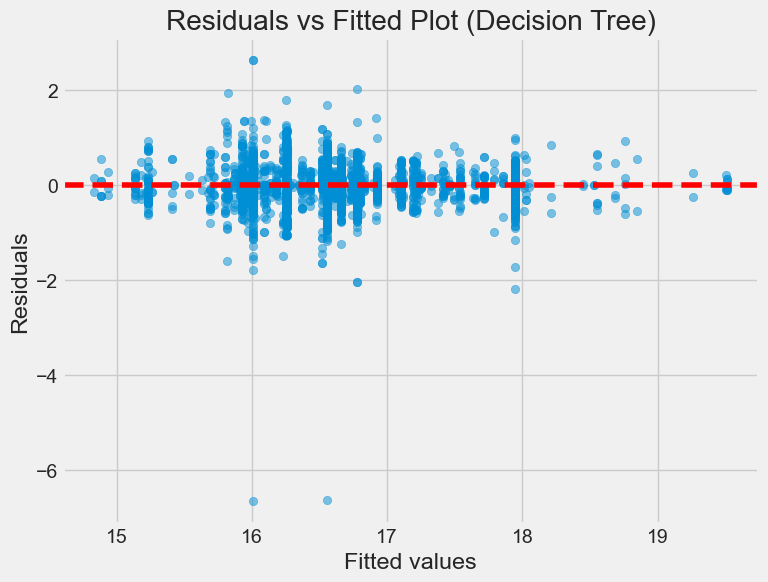

In [69]:
y_pred_train = grid_search_tree.predict(Xtrain_processed_imputed)

# Tính toán residuals
residuals = ytrain_log - y_pred_train

# Vẽ biểu đồ Residuals vs Fitted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, residuals, alpha=0.5)
plt.title('Residuals vs Fitted Plot (Decision Tree)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(y = 0, color='r', linestyle='--')  
plt.show() 

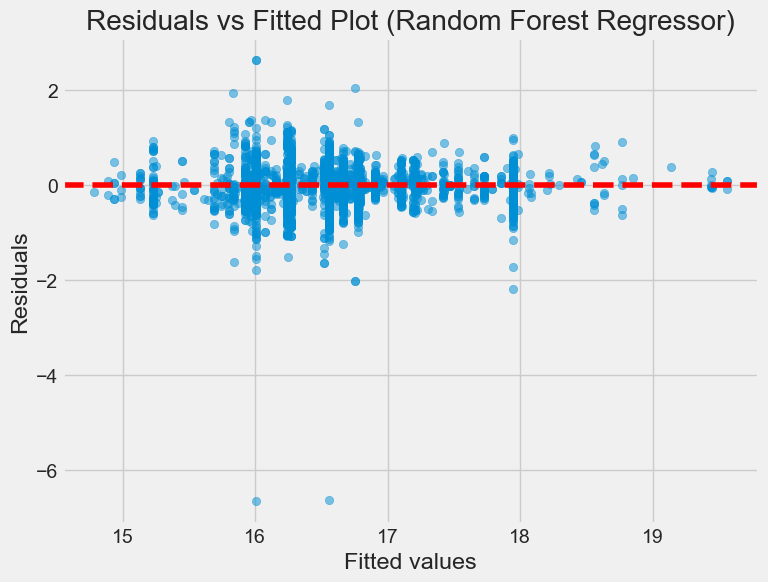

In [70]:
y_pred_train = grid_search_forest.predict(Xtrain_processed_imputed)

# Tính toán residuals
residuals = ytrain_log - y_pred_train

# Vẽ biểu đồ Residuals vs Fitted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, residuals, alpha=0.5)
plt.title('Residuals vs Fitted Plot (Random Forest Regressor)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(y = 0, color='r', linestyle='--') 
plt.show() 

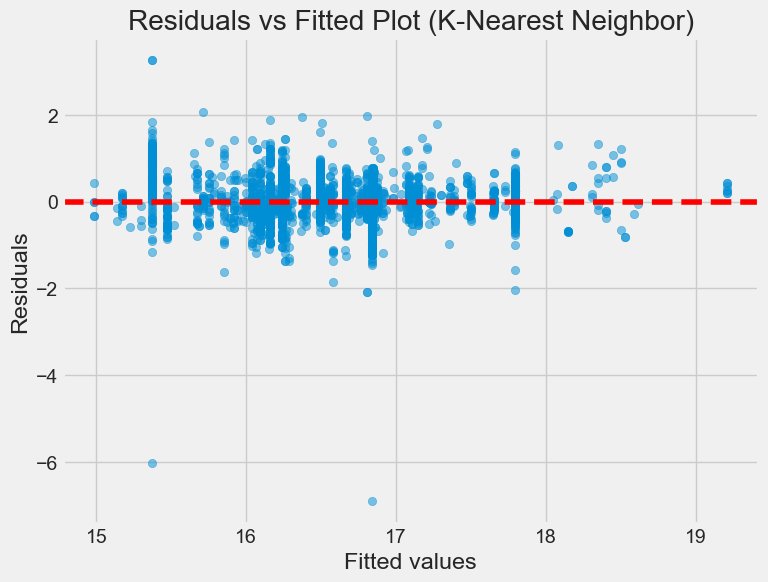

In [71]:
# Convert y_pred_train to a one-dimensional array
y_pred_train = grid_search_knn.predict(Xtrain_processed_imputed).flatten()

# Tính toán residuals
residuals = ytrain_log - y_pred_train

# Vẽ biểu đồ Residuals vs Fitted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, residuals, alpha=0.5)
plt.title('Residuals vs Fitted Plot (K-Nearest Neighbor)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(y = 0, color='r', linestyle='--')  
plt.show()


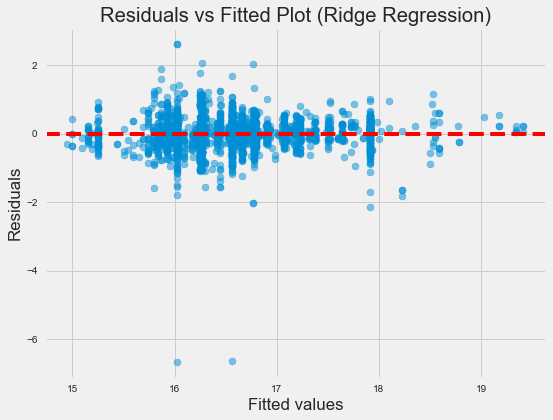

In [ ]:
# Convert y_pred_train to a one-dimensional array
y_pred_train = ridge_grid_search.predict(Xtrain_processed_imputed).flatten()

# Tính toán residuals
residuals = ytrain_log - y_pred_train

# Vẽ biểu đồ Residuals vs Fitted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, residuals, alpha=0.5)
plt.title('Residuals vs Fitted Plot (Ridge Regression)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(y = 0, color='r', linestyle='--') 
plt.show()


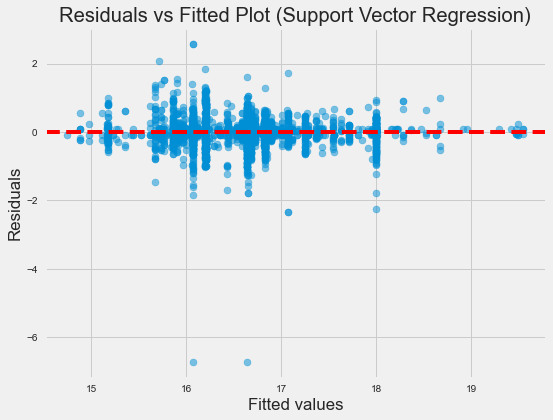

In [ ]:
# Convert y_pred_train to a one-dimensional array
y_pred_train = svr_grid_search.predict(Xtrain_processed_imputed).flatten()

# Tính toán residuals
residuals = ytrain_log - y_pred_train

# Vẽ biểu đồ Residuals vs Fitted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, residuals, alpha=0.5)
plt.title('Residuals vs Fitted Plot (Support Vector Regression)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(y = 0, color='r', linestyle='--')
plt.show()


In [ ]:
# Load the pre-trained model
model_random_forest = joblib.load('best_random_forest_model.joblib')
def predict_price():
    input_data_01 = {
        'hang': 'Honda',
        'dong': 'SH',
        'namdangki': 2021,
        'soKM': 20000,
        'tinhTrang': 'Đã sử dụng',
        'loaiXe': 'Tay ga',
        'dungTich': '100 - 175 cc',
        'chinhSachBH': 'Bảo hành hãng'
    }
    input_df_01 = pd.DataFrame([input_data_01])
    test_predict_price_01 = pipeline.transform(input_df_01)
    # Create a DataFrame with the input data
    try:
        predicted_price_01 = model_random_forest.predict(test_predict_price_01)
        predicted_price_01 = np.exp(predicted_price_01)

    except Exception as e:
        result_label.config(text=f'Error: {str(e)}')
    return  predicted_price_01
predict_price()